# XGBoost with trig tranformations on time feature

- The y-set for location A, B and C are concatonated (time index)
- The X-set for location A, B and C are concatonated (time index)
- One hot encoding for location and whether or not set is from the estimated column
- The y-set and the X-set are merged on date and location
- Having date features
- y-sets are normalized (MinMax)
- Removes repeated values in y-set B and C

It takes over from feature_engineering_1
Adds some ratio features from feature_engineering_3

**Takes over from cat_boost_clean_1.ipynb**

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import math
import csv
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
train_a = pd.read_parquet('../../A/train_targets.parquet')
train_b = pd.read_parquet('../../B/train_targets.parquet')
train_c = pd.read_parquet('../../C/train_targets.parquet')

X_train_estimated_a = pd.read_parquet('../../A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('../../B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('../../C/X_train_estimated.parquet')

X_train_observed_a = pd.read_parquet('../../A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('../../B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('../../C/X_train_observed.parquet')

X_test_estimated_a = pd.read_parquet('../../A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('../../B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('../../C/X_test_estimated.parquet')

## Handling the Y-set

In [3]:
def find_repeated_rows(df):
    '''
    Returns all indicies (from, to) which have the largest intervals of being constant. The output is sorted from 
    largest to smallest.
    '''
    df = df.reset_index()
    repeated_temp = []
    intervals = []

    first = True

    for index, row in df.iterrows():
        if index == 0:
            continue
        if row['pv_measurement'] == df.iloc[index - 1]['pv_measurement']:
            repeated_temp.append(index)
            if first: 
                repeated_temp.insert(0, index - 1)
                first = False
        else:
            if len(repeated_temp) > 1:
                intervals.append((repeated_temp[0], repeated_temp[-1]))
            repeated_temp = []
            first = True
            
    threshold = 6

    return sorted([t for t in intervals if t[1] - t[0] >= threshold], key=lambda t: t[1] - t[0], reverse=True)

In [4]:
all_y = [train_a, train_b, train_c]
labels = ['A', 'B', 'C']

table = {}

i = 0
for y in all_y:
    loc, intervals = labels[i], find_repeated_rows(y)
    if isinstance(intervals[0], (int, float)):
        intervals = np.asarray(intervals, dtype=float)
    intervals = list(intervals) + [np.nan] * (1421 - len(intervals))
    table[loc] = intervals
    print("The largest interval for", loc, intervals[0])
    i += 1

table = pd.DataFrame(table)
table.head()

The largest interval for A (5176, 5218)
The largest interval for B (13409, 14466)
The largest interval for C (18105, 18727)


,A,B,C
0,"(5176, 5218)","(13409, 14466)","(18105, 18727)"
1,"(4526, 4547)","(19138, 20141)","(26048, 26669)"
2,"(22429, 22450)","(18690, 19137)","(27224, 27748)"
3,"(22933, 22954)","(10966, 11307)","(25400, 25876)"
4,"(67, 87)","(26115, 26353)","(10047, 10375)"


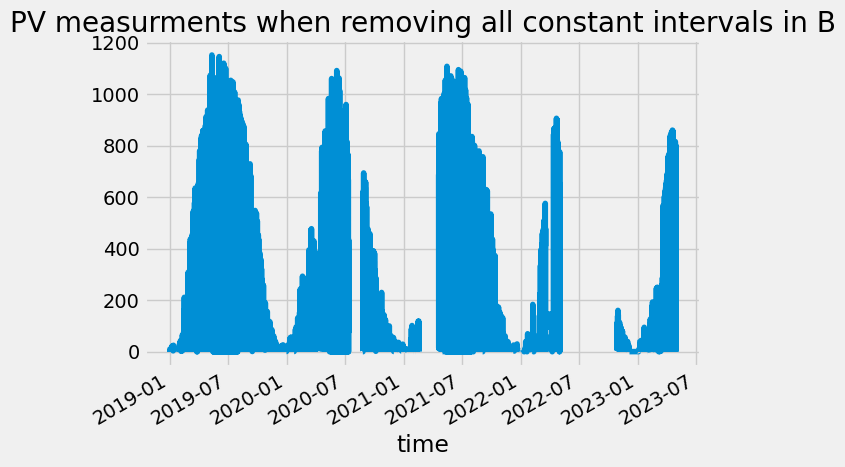

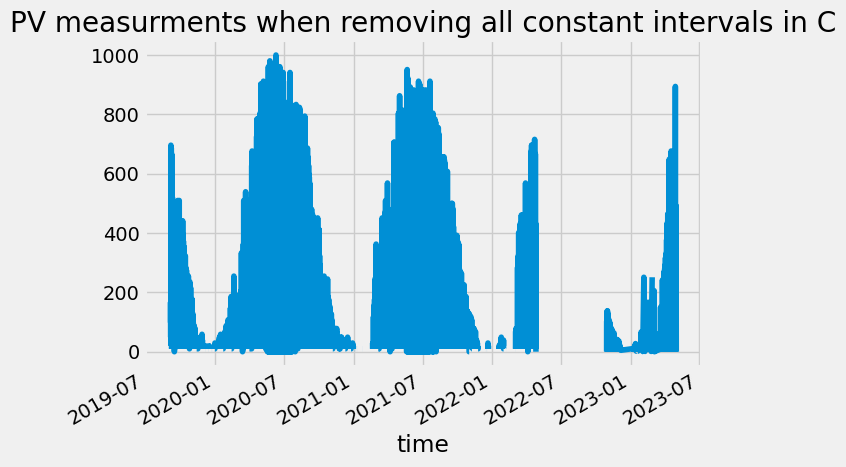

In [5]:
i = 1
for y in all_y[1:]:
    loc, intervals = labels[i], find_repeated_rows(y)
    for start, end in intervals:
        for row_index in range(start, end + 1):
            y.at[row_index, 'pv_measurement'] = np.nan

    test = y.set_index('time')
    test['pv_measurement'].plot(title="PV measurments when removing all constant intervals in " + loc)
    plt.show()
    i += 1

In [6]:
train_a.set_index('time', inplace=True)
train_b.set_index('time', inplace=True)
train_c.set_index('time', inplace=True)

Normalizing values

In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler_a = MinMaxScaler()
scaler_b = MinMaxScaler()
scaler_c = MinMaxScaler()

In [8]:
train_a['pv_measurement'] = scaler_a.fit_transform(train_a[['pv_measurement']])
train_b['pv_measurement'] = scaler_b.fit_transform(train_b[['pv_measurement']])
train_c['pv_measurement'] = scaler_c.fit_transform(train_c[['pv_measurement']])

In [9]:
train_a['location'] = 'A'
train_b['location'] = 'B'
train_c['location'] = 'C'

In [10]:
y = pd.concat([train_a, train_b, train_c])
y.index.name = 'time'

y.shape
y.head()

,pv_measurement,location
time,,
2019-06-02 22:00:00,0.000000,A
2019-06-02 23:00:00,0.000000,A
2019-06-03 00:00:00,0.000000,A
2019-06-03 01:00:00,0.000000,A
2019-06-03 02:00:00,0.003377,A


Setting the index to **date_forecast** and resampling with median.

In [11]:

X_train_observed_a['date_forecast'] = pd.to_datetime(X_train_observed_a['date_forecast'])
X_train_observed_a.set_index('date_forecast', inplace=True)
if "date_calc" in X_train_observed_a:
    X_train_observed_a.drop("date_calc", axis=1, inplace=True)
X_train_observed_a = X_train_observed_a.resample('60min').median()


X_train_estimated_a['date_forecast'] = pd.to_datetime(X_train_estimated_a['date_forecast'])
X_train_estimated_a.set_index('date_forecast', inplace=True)
if "date_calc" in X_train_estimated_a:
    X_train_estimated_a.drop("date_calc", axis=1, inplace=True)
X_train_estimated_a = X_train_estimated_a.resample('60min').median()


X_train_observed_b['date_forecast'] = pd.to_datetime(X_train_observed_b['date_forecast'])
X_train_observed_b.set_index('date_forecast', inplace=True)
if "date_calc" in X_train_observed_b:
    X_train_observed_b.drop("date_calc", axis=1, inplace=True)
X_train_observed_b = X_train_observed_b.resample('60min').median()


X_train_estimated_b['date_forecast'] = pd.to_datetime(X_train_estimated_b['date_forecast'])
X_train_estimated_b.set_index('date_forecast', inplace=True)
if "date_calc" in X_train_estimated_b:
    X_train_estimated_b.drop("date_calc", axis=1, inplace=True)
X_train_estimated_b = X_train_estimated_b.resample('60min').median()


X_train_observed_c['date_forecast'] = pd.to_datetime(X_train_observed_c['date_forecast'])
X_train_observed_c.set_index('date_forecast', inplace=True)
if "date_calc" in X_train_observed_c:
    X_train_observed_c.drop("date_calc", axis=1, inplace=True)
X_train_observed_c = X_train_observed_c.resample('60min').median()


X_train_estimated_c['date_forecast'] = pd.to_datetime(X_train_estimated_c['date_forecast'])
X_train_estimated_c.set_index('date_forecast', inplace=True)
if "date_calc" in X_train_estimated_c:
    X_train_estimated_c.drop("date_calc", axis=1, inplace=True)
X_train_estimated_c = X_train_estimated_c.resample('60min').median()


In [12]:
def replace_outliers_with_nan(df, feature):
    '''Replaces thr 0.01 and 0.99'''
    Q1 = df[feature].quantile(0.01)
    Q99 = df[feature].quantile(0.99)

    df[feature] = np.where(
        (df[feature] < Q1) | (df[feature] > Q99),
        np.nan,
        df[feature]
    )

### Removing 'outlier' features as this gave us 0.1 better score on Kaggle

In [13]:
outliers = ['air_density_2m:kgm3', 'msl_pressure:hPa', 'sfc_pressure:hPa']


for o in outliers:
    replace_outliers_with_nan(X_train_observed_a, o)
    replace_outliers_with_nan(X_train_observed_b, o)
    replace_outliers_with_nan(X_train_observed_c, o)

In [14]:
X_train_observed_a['location'], X_train_estimated_a['location'] = 'A', 'A'
X_train_observed_b['location'], X_train_estimated_b['location']= 'B', 'B'
X_train_observed_c['location'], X_train_estimated_c['location']= 'C', 'C'

X_train_observed_a['estimated'], X_train_estimated_a['estimated'] = 0, 1
X_train_observed_b['estimated'], X_train_estimated_b['estimated'] = 0, 1
X_train_observed_c['estimated'], X_train_estimated_c['estimated'] = 0, 1

In [15]:
X = pd.concat([X_train_observed_a, X_train_estimated_a, X_train_observed_b,
               X_train_estimated_b, X_train_observed_c, X_train_estimated_c
               ], ignore_index=False)
X = X.sort_index()

In [16]:
df = pd.merge(y, X, left_on=[y.index, 'location'],
              right_on=[X.index, 'location'])

df.set_index('key_0', inplace=True)
df.index.name = "time"
df = df.sort_index()

df.head()

,pv_measurement,location,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,...,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,estimated
time,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,NaN,B,5.55,1.2395,1200.700012,0.0,0.0,1200.700012,0.0,275.150009,...,-48.389500,0.0,278.250000,87.500000,16823.399902,2.80,1.20,2.55,-0.0,0
2019-01-01 00:00:00,NaN,C,5.45,1.2410,1130.049988,0.0,0.0,1130.049988,1.0,275.000000,...,-48.426498,0.0,278.349991,85.350002,16512.299805,2.90,1.10,2.65,-0.0,0
2019-01-01 01:00:00,NaN,C,5.35,1.2400,1066.699951,0.0,0.0,1066.699951,1.0,274.650009,...,-45.002501,0.0,278.200012,99.099998,13277.399902,3.65,1.40,3.35,-0.0,0
2019-01-01 01:00:00,NaN,B,5.40,1.2395,1131.449951,0.0,0.0,1131.449951,0.0,274.849991,...,-44.971498,0.0,278.100006,99.099998,12777.449707,3.55,1.50,3.20,-0.0,0
2019-01-01 02:00:00,NaN,B,5.40,1.2385,1061.049988,0.0,0.0,1061.049988,0.0,274.800003,...,-39.896000,0.1,278.050003,97.849998,11142.549805,4.05,2.15,3.45,-0.0,0


In [17]:
def create_features(df):
    """
    Create Features
    """
    
    df = df.copy()
    df['month_sin'] = np.sin(2 * np.pi * df.index.month / 12)
    df['month_cos'] = np.cos(2 * np.pi * df.index.month / 12)
    df['hour_sin'] = np.sin(2 * np.pi * df.index.hour / 23)
    df['hour_cos'] = np.cos(2 * np.pi * df.index.hour / 23)

    return df

def get_season(month):
    if 3 <= month <= 5:
        return 0  # spring
    elif 6 <= month <= 8:
        return 1  # summer
    elif 9 <= month <= 11:
        return 2  # fall
    else:
        return 3  # winter

df = create_features(df)

df.head()

,pv_measurement,location,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,...,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,estimated,month_sin,month_cos,hour_sin,hour_cos
time,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,NaN,B,5.55,1.2395,1200.700012,0.0,0.0,1200.700012,0.0,275.150009,...,16823.399902,2.80,1.20,2.55,-0.0,0,0.5,0.866025,0.000000,1.000000
2019-01-01 00:00:00,NaN,C,5.45,1.2410,1130.049988,0.0,0.0,1130.049988,1.0,275.000000,...,16512.299805,2.90,1.10,2.65,-0.0,0,0.5,0.866025,0.000000,1.000000
2019-01-01 01:00:00,NaN,C,5.35,1.2400,1066.699951,0.0,0.0,1066.699951,1.0,274.650009,...,13277.399902,3.65,1.40,3.35,-0.0,0,0.5,0.866025,0.269797,0.962917
2019-01-01 01:00:00,NaN,B,5.40,1.2395,1131.449951,0.0,0.0,1131.449951,0.0,274.849991,...,12777.449707,3.55,1.50,3.20,-0.0,0,0.5,0.866025,0.269797,0.962917
2019-01-01 02:00:00,NaN,B,5.40,1.2385,1061.049988,0.0,0.0,1061.049988,0.0,274.800003,...,11142.549805,4.05,2.15,3.45,-0.0,0,0.5,0.866025,0.519584,0.854419


### Selecting features

Everything except:

- snow_density:kgm3
- cloud_base_agl:m
- ceiling_height_agl:m

They have a lot of NaN values.

In [18]:
FEATURES = [
    'absolute_humidity_2m:gm3', 'air_density_2m:kgm3',
    'clear_sky_energy_1h:J', 'clear_sky_rad:W',
    'dew_or_rime:idx', 'dew_point_2m:K',
    'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
    'effective_cloud_cover:p', 'elevation:m', 'fresh_snow_12h:cm',
    'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm',
    'fresh_snow_6h:cm', 'is_day:idx', 'is_in_shadow:idx',
    'msl_pressure:hPa', 'precip_5min:mm', 'precip_type_5min:idx',
    'pressure_100m:hPa', 'pressure_50m:hPa', 'prob_rime:p',
    'rain_water:kgm2', 'relative_humidity_1000hPa:p', 'sfc_pressure:hPa',
    'snow_depth:cm', 'snow_drift:idx',
    'snow_melt_10min:mm', 'snow_water:kgm2', 'sun_azimuth:d',
    'sun_elevation:d', 'super_cooled_liquid_water:kgm2', 't_1000hPa:K',
    'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms',
    'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms', 'wind_speed_w_1000hPa:ms',
    'month_sin', 'month_cos', 'hour_sin', 'hour_cos',
    'location'
]

TARGET = 'pv_measurement'

In [19]:
relevant = FEATURES.copy()
relevant.append(TARGET)

df = df[relevant]

In [20]:
print(df.isna().sum())
before = df.shape

train = df.dropna()
print(train.isna().sum())
after = train.shape

dif = before[0] - after[0]

df = df.dropna()
print("DROPNA RESULTED IN", dif, "ROWS BEING DROPPED. THE DATASET HAS", after[0], "ROWS IN TOTAL.")

absolute_humidity_2m:gm3             72
air_density_2m:kgm3                1824
clear_sky_energy_1h:J                72
clear_sky_rad:W                      72
dew_or_rime:idx                      72
dew_point_2m:K                       72
diffuse_rad:W                        72
diffuse_rad_1h:J                     72
direct_rad:W                         72
direct_rad_1h:J                      72
effective_cloud_cover:p              72
elevation:m                          72
fresh_snow_12h:cm                    72
fresh_snow_1h:cm                     72
fresh_snow_24h:cm                    72
fresh_snow_3h:cm                     72
fresh_snow_6h:cm                     72
is_day:idx                           72
is_in_shadow:idx                     72
msl_pressure:hPa                   1832
precip_5min:mm                       72
precip_type_5min:idx                 72
pressure_100m:hPa                    72
pressure_50m:hPa                     72
prob_rime:p                          72


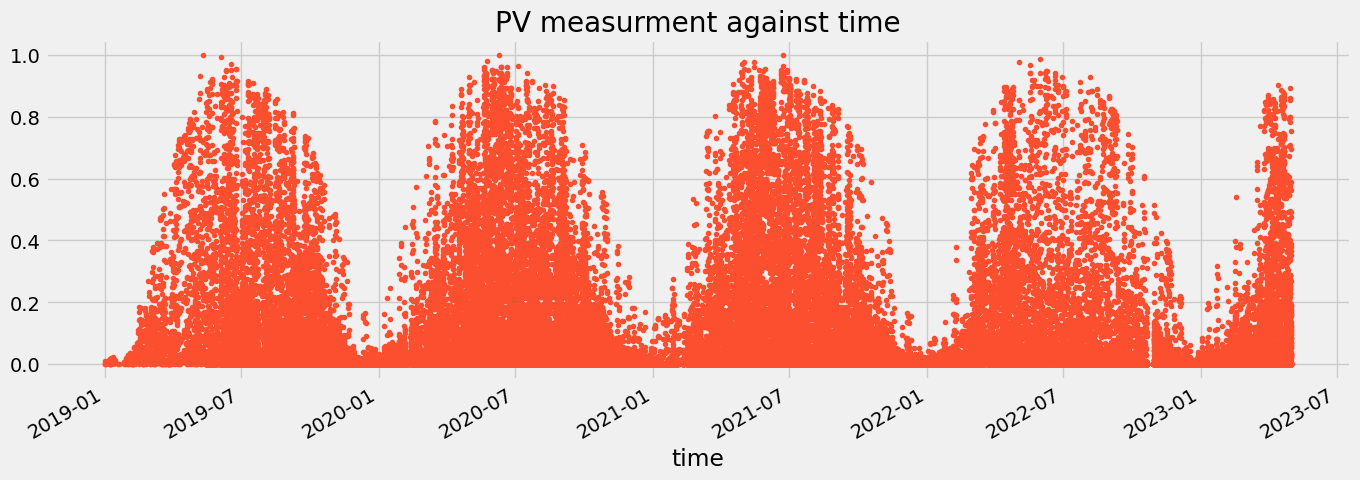

In [21]:
color_pal = sns.color_palette()

df["pv_measurement"].plot(style='.',
        figsize=(15, 5),
        color=color_pal[1],
        title='PV measurment against time')
plt.show()

### Preparing test data

- Excluding dates that should not be tested
- Including only the features we have defined

In [75]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

def prepare_test_data(x, location):
    x_test = x.copy()
    x_test.set_index('date_forecast', inplace = True)
    x_test.drop('date_calc', axis=1, inplace = True)
    x_test['estimated'] = 1

    x_test = x_test.resample('60min').median()

    x_test = create_features(x_test)

    x_test['location'] = location

    return x_test

In [76]:
x_test_a = prepare_test_data(X_test_estimated_a, 'A')
x_test_b = prepare_test_data(X_test_estimated_b, 'B')
x_test_c = prepare_test_data(X_test_estimated_c, 'C')

In [77]:
test_sub = pd.read_csv('../../test.csv')
valid_dates = pd.to_datetime(test_sub['time'].unique())

In [78]:
x_test_a = x_test_a.loc[valid_dates]
x_test_b = x_test_b.loc[valid_dates]
x_test_c = x_test_c.loc[valid_dates]

In [79]:
X_test = pd.concat([x_test_a, x_test_b, x_test_c])
X_test = X_test[FEATURES]

In [80]:
X_test_kaggle = X_test

### Disability Check

Check if the training data and the test data contains the same columns.

In [28]:
check_df = df.copy()
check_train = check_df[FEATURES]
if X_test.columns.equals(check_train.columns):
    print("EQUAL")
else:
    print("NOT EQUAL")
    print("DIFFERENCE\n", X_test.columns.difference(check_train.columns))

EQUAL


Check if test data has the right amount of rows.

In [29]:
if X_test.shape[0] != 2160:
    print("X_test has wrong amount of rows!")
    print("Shape =", X_test.shape[0])
else:
    print("GOOD")

GOOD


In [30]:
X, y = df[FEATURES], df[TARGET]

In [31]:
X['location'] = X['location'].astype('category')

/var/folders/s2/v6q39rgs1xs8ww30dn78jkb00000gn/T/ipykernel_6403/1794122678.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['location'] = X['location'].astype('category')


In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test_local, y_train, y_test_local = train_test_split(X, y, test_size=0.15, random_state=42)

### Define parameters you want to tune

NOTE we have gotten issues by tuning too many paramters. Be carefull!

In [33]:
import optuna
import xgboost as xg
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)


def objective(trial):
    param = {
        "eval_metric": 'mae',  
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.3, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 50, 1500),
        "max_depth": trial.suggest_int("max_depth", 1, 15),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),
        'enable_categorical':True
    }

    cv = KFold(n_splits=5)

    model = XGBRegressor(**param)

    maes = []

    for train_index, val_index in cv.split(X_train):
        train_x, val_x = X_train.iloc[train_index], X_train.iloc[val_index]
        train_y , val_y = y_train.iloc[train_index], y_train.iloc[val_index]

        model.fit(train_x, train_y, verbose=0)
        y_pred = model.predict(val_x)
        mae = mean_absolute_error(val_y, y_pred)
        maes.append(mae)
        
    avg_mae = np.mean(maes)

    return avg_mae


In [34]:
xg.__version__

'2.0.0'

### Specify number of trials

A higher number of trials tries out more parameters

In [35]:
trials = 60

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=trials, n_jobs=-1, show_progress_bar=True)  

[I 2023-10-28 23:34:01,322] A new study created in memory with name: no-name-1c6311c5-a1dd-441f-84a0-27faf0cbafcb


  0%|          | 0/60 [00:00<?, ?it/s]

[I 2023-10-28 23:34:28,558] Trial 3 finished with value: 0.11859464749481133 and parameters: {'learning_rate': 0.006617105398437119, 'n_estimators': 64, 'max_depth': 8, 'colsample_bytree': 0.1490978625814382}. Best is trial 3 with value: 0.11859464749481133.
[I 2023-10-28 23:36:03,550] Trial 7 finished with value: 0.04018942761164117 and parameters: {'learning_rate': 0.2063032858410021, 'n_estimators': 805, 'max_depth': 3, 'colsample_bytree': 0.24293737874881377}. Best is trial 7 with value: 0.04018942761164117.
[I 2023-10-28 23:38:03,674] Trial 2 finished with value: 0.03448439681432367 and parameters: {'learning_rate': 0.009449235940674192, 'n_estimators': 502, 'max_depth': 9, 'colsample_bytree': 0.863268807428833}. Best is trial 2 with value: 0.03448439681432367.
[I 2023-10-28 23:39:00,037] Trial 5 finished with value: 0.04130533788424024 and parameters: {'learning_rate': 0.009086907602114105, 'n_estimators': 1370, 'max_depth': 4, 'colsample_bytree': 0.30426023098490196}. Best is tr

In [39]:
best_params = study.best_params
print('Best parameters:', best_params)

#Best parameters: {'iterations': 854, 'learning_rate': 0.017432099489773544, 'depth': 14, 'colsample_bylevel': 0.43559465187532453, 'min_data_in_leaf': 257, 'l2_leaf_reg': 9.179321889625692, 'border_count': 129, 'random_strength': 0.8781261706316226, 'bagging_temperature': 11.599929150721326, 'grow_policy': 'Lossguide', 'max_leaves': 192}

Best parameters: {'learning_rate': 0.026677849047960514, 'n_estimators': 1407, 'max_depth': 10, 'colsample_bytree': 0.6216020606305356}


### Now visualising the predictions

This is done by using the validation sets from cross validation. We have used Timeseries cross validation with a test size of three months (that which we are trying to predict in our test sets).

In [67]:
model = XGBRegressor(**best_params, enable_categorical=True)

In [56]:
model.fit(X_train, y_train, verbose=0)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6216020606305356, device=None,
             early_stopping_rounds=None, enable_categorical=True,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.026677849047960514, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1407, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [57]:
pred_local = model.predict(X_test_local)

In [58]:
from sklearn.metrics import mean_squared_error
test_score = mean_squared_error(y_test_local, pred_local)
print("Test Score:", test_score)

Test Score: 0.003054853099137965


In [59]:
residuals = y_test_local - pred_local

In [60]:
color_pal = sns.color_palette()

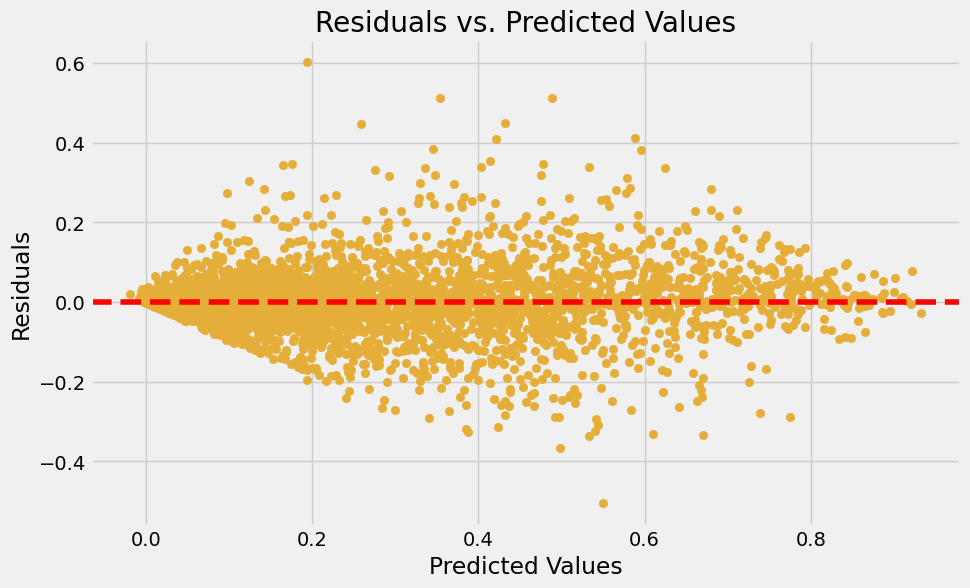

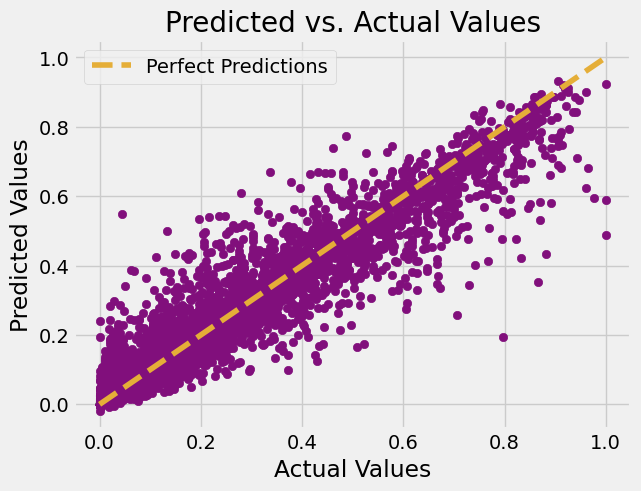

In [61]:
# RESIDUALS
plt.figure(figsize=(10, 6))
plt.scatter(pred_local, residuals, color=color_pal[2])
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values')
plt.show()

# PRED vs. ACTUAL
plt.scatter(y_test_local, pred_local, color=color_pal[5])
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. Actual Values')
plt.plot([min(y_test_local), max(y_test_local)], [min(y_test_local), max(y_test_local)], color=color_pal[2], linestyle='--', label='Perfect Predictions')
plt.legend()

# THE MAIN FIGURE TO WORRY ABOUT

### Residual = Actual - Pred

In [62]:
print("The average residuals:")
print(np.mean(residuals))

The average residuals:
-9.383242831948019e-05


In [72]:
model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6216020606305356, device=None,
             early_stopping_rounds=None, enable_categorical=True,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.026677849047960514, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1407, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### Predict and make csv

In [81]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
X_test_kaggle['location'] = le.fit_transform(X_test_kaggle['location'])


In [82]:
predictions = model.predict(X_test_kaggle)

In [83]:
predictions = pd.DataFrame(predictions, columns=['prediction'])

predictions.reset_index(drop=True, inplace=True)

predictions.head()

,prediction
0,-0.000448
1,0.000178
2,0.000113
3,0.010504
4,0.061457


In [84]:
loc_a = predictions.iloc[:len(predictions)//3]
loc_b = predictions.iloc[len(predictions)//3:2*len(predictions)//3]
loc_c = predictions.iloc[2*len(predictions)//3:]

In [85]:
n = len(predictions)

# De-normalizing

loc_a.loc[:, 'prediction'] = scaler_a.inverse_transform(loc_a['prediction'].values.reshape(-1, 1))
loc_b.loc[:, 'prediction'] = scaler_b.inverse_transform(loc_b['prediction'].values.reshape(-1, 1))
loc_c.loc[:, 'prediction'] = scaler_c.inverse_transform(loc_c['prediction'].values.reshape(-1, 1))

In [86]:
predictions = pd.concat([loc_a, loc_b, loc_c])

In [87]:
predictions.head(10)

,prediction
0,-2.567349
1,1.021431
2,0.648480
3,60.225681
4,352.356567
5,733.777405
6,1543.819580
7,2793.329834
8,2877.330566
9,2629.053955


In [88]:
predictions.reset_index(inplace=True)
predictions.rename(columns={'index': 'id'}, inplace=True)
predictions.to_csv('predictions.csv', index=False)

Remove negative values

In [89]:
predictions.loc[predictions['prediction'] < 0, 'prediction'] = 0
predictions.to_csv('predictions.csv', index=False)

Redifing the training sets

In [90]:
train_a = pd.read_parquet('../../A/train_targets.parquet')
train_b = pd.read_parquet('../../B/train_targets.parquet')
train_c = pd.read_parquet('../../C/train_targets.parquet')

train_a.set_index('time', inplace=True)
train_b.set_index('time', inplace=True)
train_c.set_index('time', inplace=True)

### Plotting A

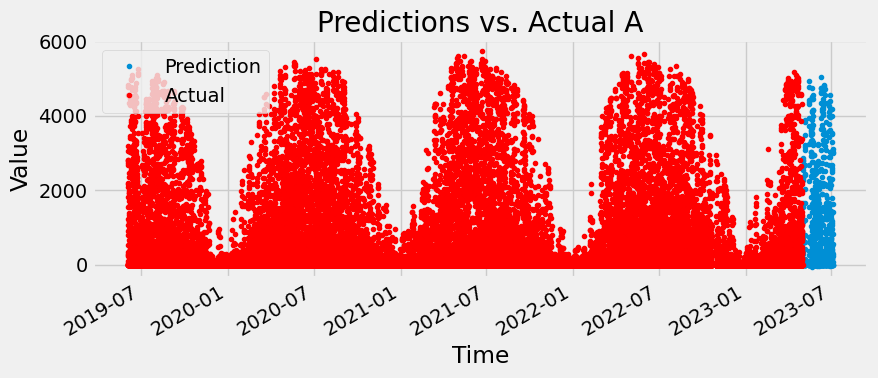

In [91]:
loc_a.set_index(valid_dates, inplace=True)

plt.figure(figsize=(9, 4))

loc_a['prediction'].plot(style='.', label='Prediction')
train_a['pv_measurement'].plot(style='.', label='Actual', color='red', linewidth=2)

plt.legend(loc='upper left')
plt.title('Predictions vs. Actual A')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()
plt.show()

### Plotting B

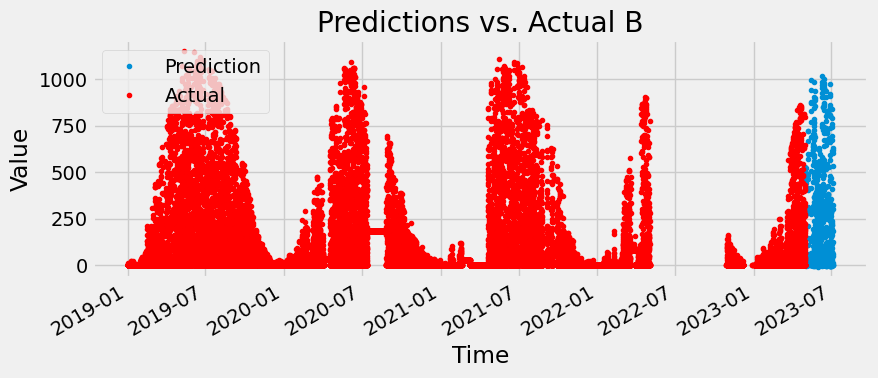

In [92]:
loc_b.set_index(valid_dates, inplace=True)

plt.figure(figsize=(9, 4))

loc_b['prediction'].plot(style='.', label='Prediction')
train_b['pv_measurement'].plot(style='.', label='Actual', color='red', linewidth=2)

plt.legend(loc='upper left')
plt.title('Predictions vs. Actual B')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()
plt.show()


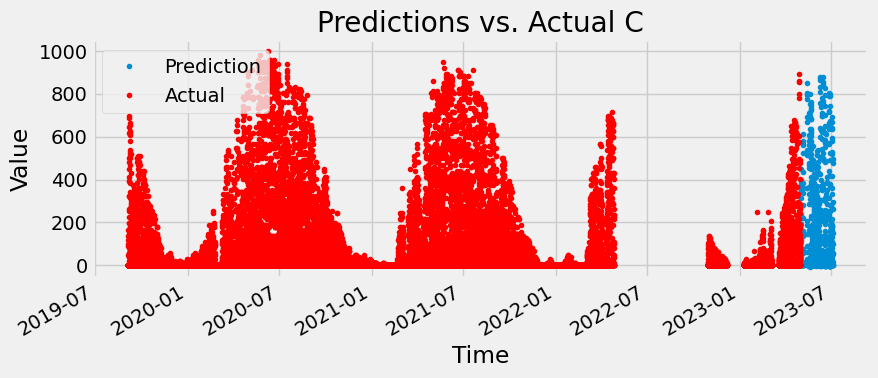

In [93]:
loc_c.set_index(valid_dates, inplace=True)

plt.figure(figsize=(9, 4))

loc_c['prediction'].plot(style='.', label='Prediction')
train_c['pv_measurement'].plot(style='.', label='Actual', color='red', linewidth=2)

plt.legend(loc='upper left')
plt.title('Predictions vs. Actual C')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()
plt.show()